# Zebrafish behavior classification with unsupervised clustering

Here, we will be investigating the types of behaviors present in our data by clustering them based
on kinematic parameters measured by DeepBLU-Z

Reading in and reshaping data:

The data is saved with the columns ["fish number", "trial number", "plane number", "behavior data"]

For this analysis, we need to go through and build an n_behaviors x n_parameters matrix by pulling out
the parameters for each behavior in each trial.

In [1]:
import scipy.io
mat = scipy.io.loadmat('/media/userman/249272E19272B6C0/Documents and Settings/jbarr/Documents/Douglass Lab/2019/'
                       'Calcim Imaging/4-24-18_to_5-3-18/behaviorDataAll_42418to5318_3_101318.mat')

In [2]:
import numpy as np

# Get behavior data column
trial_data = mat['behaviorDataAll'][:, 3]

# for each trial, for each behavior, append parameters
behavior_parameters = np.zeros([1, 59])
for trial_number in range(trial_data.shape[0]):
    bhavs = trial_data[trial_number]
    for bhav_number in range(bhavs.shape[1]):
        behavior_parameters = np.append(behavior_parameters, bhavs[0, bhav_number], 0)
behavior_parameters = np.delete(behavior_parameters, 0, 0)

print(behavior_parameters.shape)

(2299, 59)


Before we try running k-means, let's reduce the dimensionality. Let's see how much of the variance is
in the first 10 principle components

In [3]:
# First, scale the data to mean 0 and variance 1 for PCA
from sklearn.preprocessing import StandardScaler
scaled_parameters = StandardScaler().fit_transform(behavior_parameters)

# run PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(scaled_parameters)

print(pca.explained_variance_ratio_.cumsum())

[0.33730826 0.43891559 0.50439271 0.55644471 0.60173062 0.64545096
 0.68284536 0.71434681 0.73972038 0.76312859 0.7827255  0.80006123
 0.81613637 0.83017439 0.84246039 0.85432177 0.86498355 0.87529338
 0.88425567 0.89274435]


About 50% of the variance is in the first 3 PCs. Let's see how well k-means can cluster the data with them.

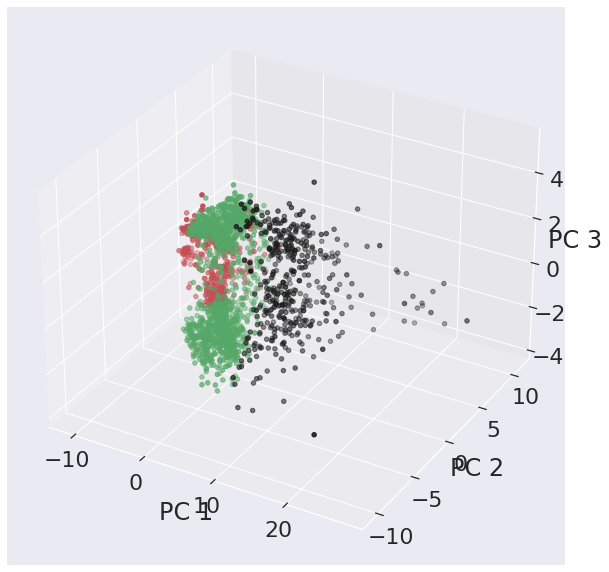

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3)
kmeans.fit(principalComponents[:, 0:2])

# visualize results
import matplotlib.pyplot as plt

fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,20)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principalComponents[kmeans.labels_ == 0, 0], principalComponents[kmeans.labels_ == 0, 1], principalComponents[kmeans.labels_ == 0, 2], c='k', marker='o')
ax.scatter(principalComponents[kmeans.labels_ == 1, 0], principalComponents[kmeans.labels_ == 1, 1], principalComponents[kmeans.labels_ == 1, 2], c='r', marker='o')
ax.scatter(principalComponents[kmeans.labels_ == 2, 0], principalComponents[kmeans.labels_ == 2, 1], principalComponents[kmeans.labels_ == 2, 2], c='g', marker='o')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

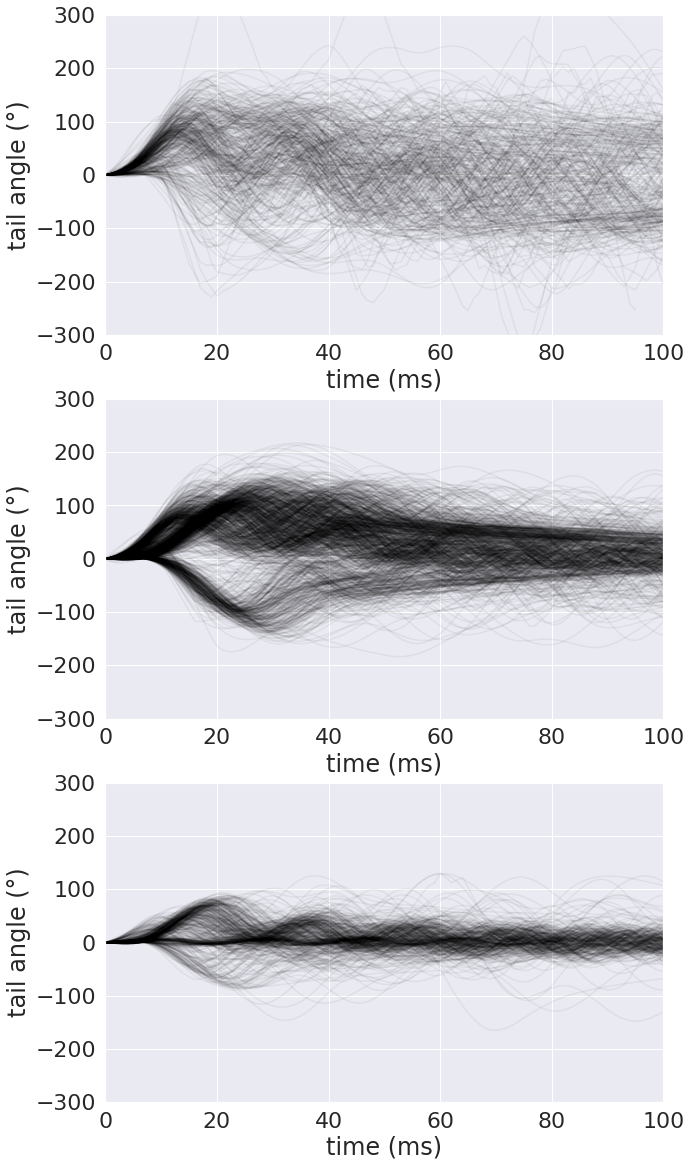

In [6]:
import seaborn as sns
import matplotlib
# plot traces of each cluster

def get_trace(ind):
    count = 0
    for trial_num in range(trial_data.shape[0]):
        trial = trial_data[trial_num]
        for behavior_num in range(trial.shape[1]):
            if count == ind:
                trace = np.squeeze(trial[1, behavior_num])
                # normalize to initial value to zero for plotting clarity
                trace = trace - trace[0]
                # if initial deflection is down, invert trace
                if np.mean(trace[0:10]) < 0:
                    trace = -trace
                return trace
            else:
                count = count + 1

# frame rate is 500Hz, set to plot by seconds
fr = 500

fig, axs = plt.subplots(nrows=kmeans.n_clusters)
sns.set(font_scale=2)
for cluster_num in range(kmeans.n_clusters):
    for x in np.where(kmeans.labels_ == cluster_num)[0]:
        trace = get_trace(x)
        plot = sns.lineplot(range(trace.shape[0]), np.squeeze(trace),
                            ax=axs[cluster_num],
                            color='black',
                            alpha=0.05)
        plot.set(xlim=(0, 100))
        plot.set_xlabel('time (ms)')
        plot.set(ylim=(-300, 300))
        plot.set_ylabel('tail angle (°)')
plt.rcParams["figure.figsize"] = (10,20)
plt.show()